<a href="https://colab.research.google.com/github/channachot/Project1/blob/master/Project3_VariationalAutoencoder1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

import os
from glob import glob

WEIGHTS_FOLDER = 'weights'
DATA_FOLDER = '/content/drive/My Drive/colab/'

if not os.path.exists(WEIGHTS_FOLDER):
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/colab/animefacedataset.zip', 'r') as zipObj:
    #Extract all the contents of zip file in the data directory
    zipObj.extractall('/content/drive/My Drive/colab/')

In [6]:
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model

Using TensorFlow backend.


In [7]:
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 63565


In [8]:
INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 512
Z_DIM = 200 # Dimension of the latent vector (z)

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

Found 63565 images belonging to 1 classes.


# Model VariationalAutoencoder

In [0]:
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides, use_batch_norm = False, use_dropout = False):
  
  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model 
  # would be inconsistent
  global K
  K.clear_session()
  
  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)
      if use_batch_norm:
        x = BathcNormalization()(x)
  
      x = LeakyReLU()(x)

      if use_dropout:
        x = Dropout(rate=0.25)(x)

  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = Flatten()(x)
  
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   
  
  # Using a Keras Lambda Layer to include the sampling function as a layer 
  # in the model
  encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])

  return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)

In [19]:
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

vae_encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 32, 32, 64)   18496       leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

In [0]:
# Decoder
def build_decoder(input_dim, vae_shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(vae_shape_before_flattening))(decoder_input)
  x = Reshape(vae_shape_before_flattening)(x)

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      
      # Adding a sigmoid layer at the end to restrict the outputs 
      # between 0 and 1
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)

  # Define model output
  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)

In [21]:
vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
                                        vae_shape_before_flattening = vae_shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
vae_decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              823296    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 64)        0   

In [22]:
# The input to the model will be the image fed to the encoder.
vae_input = vae_encoder_input

# Output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae_model = Model(vae_input, vae_output)

vae_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 32, 32, 64)   18496       leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

In [0]:
LEARNING_RATE = 0.005
N_EPOCHS = 20
LOSS_FACTOR = 1000

In [0]:
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

In [0]:
adam_optimizer = Adam(lr = LEARNING_RATE)

vae_model.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/weights.h5'), save_weights_only = True, verbose=1)

In [26]:
vae_model.fit_generator(data_flow, 
                        shuffle=True, 
                        epochs = N_EPOCHS, 
                        initial_epoch = 0, 
                        steps_per_epoch=NUM_IMAGES / BATCH_SIZE,
                        callbacks=[checkpoint_vae])

Epoch 1/20
125/124 [==============================] - 356s 3s/step - loss: 192.3627 - r_loss: 0.0690 - kl_loss: 124.0215

Epoch 00001: saving model to weights/VAE/weights.h5
Epoch 2/20
125/124 [==============================] - 356s 3s/step - loss: 56.3012 - r_loss: 0.0522 - kl_loss: 4.1332

Epoch 00002: saving model to weights/VAE/weights.h5
Epoch 3/20
125/124 [==============================] - 356s 3s/step - loss: 53.8322 - r_loss: 0.0490 - kl_loss: 4.8133

Epoch 00003: saving model to weights/VAE/weights.h5
Epoch 4/20
125/124 [==============================] - 361s 3s/step - loss: 51.2473 - r_loss: 0.0464 - kl_loss: 4.8070

Epoch 00004: saving model to weights/VAE/weights.h5
Epoch 5/20
125/124 [==============================] - 364s 3s/step - loss: 49.8654 - r_loss: 0.0444 - kl_loss: 5.4358

Epoch 00005: saving model to weights/VAE/weights.h5
Epoch 6/20
125/124 [==============================] - 360s 3s/step - loss: 49.2048 - r_loss: 0.0435 - kl_loss: 5.7563

Epoch 00006: saving mod

In [0]:
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

In [0]:
def plot_compare_vae(images=None):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]
  reconst_images = vae_model.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)

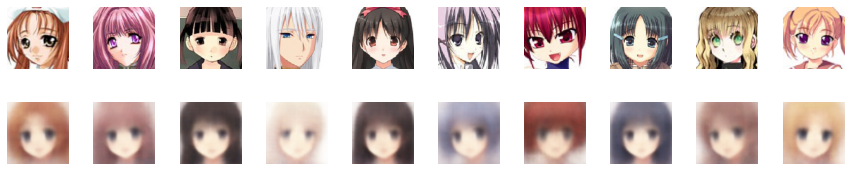

In [31]:
import matplotlib.pyplot as plt
plot_compare_vae(images = example_images)

In [0]:
def vae_generate_images(n_to_show=10):
  reconst_images = vae_decoder.predict(np.random.normal(0,1,size=(n_to_show,Z_DIM)))

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img)

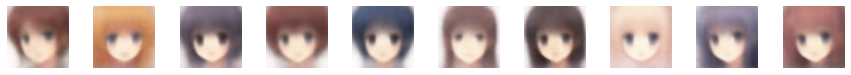

In [33]:
vae_generate_images(n_to_show=10)

In [0]:
from scipy.stats import norm

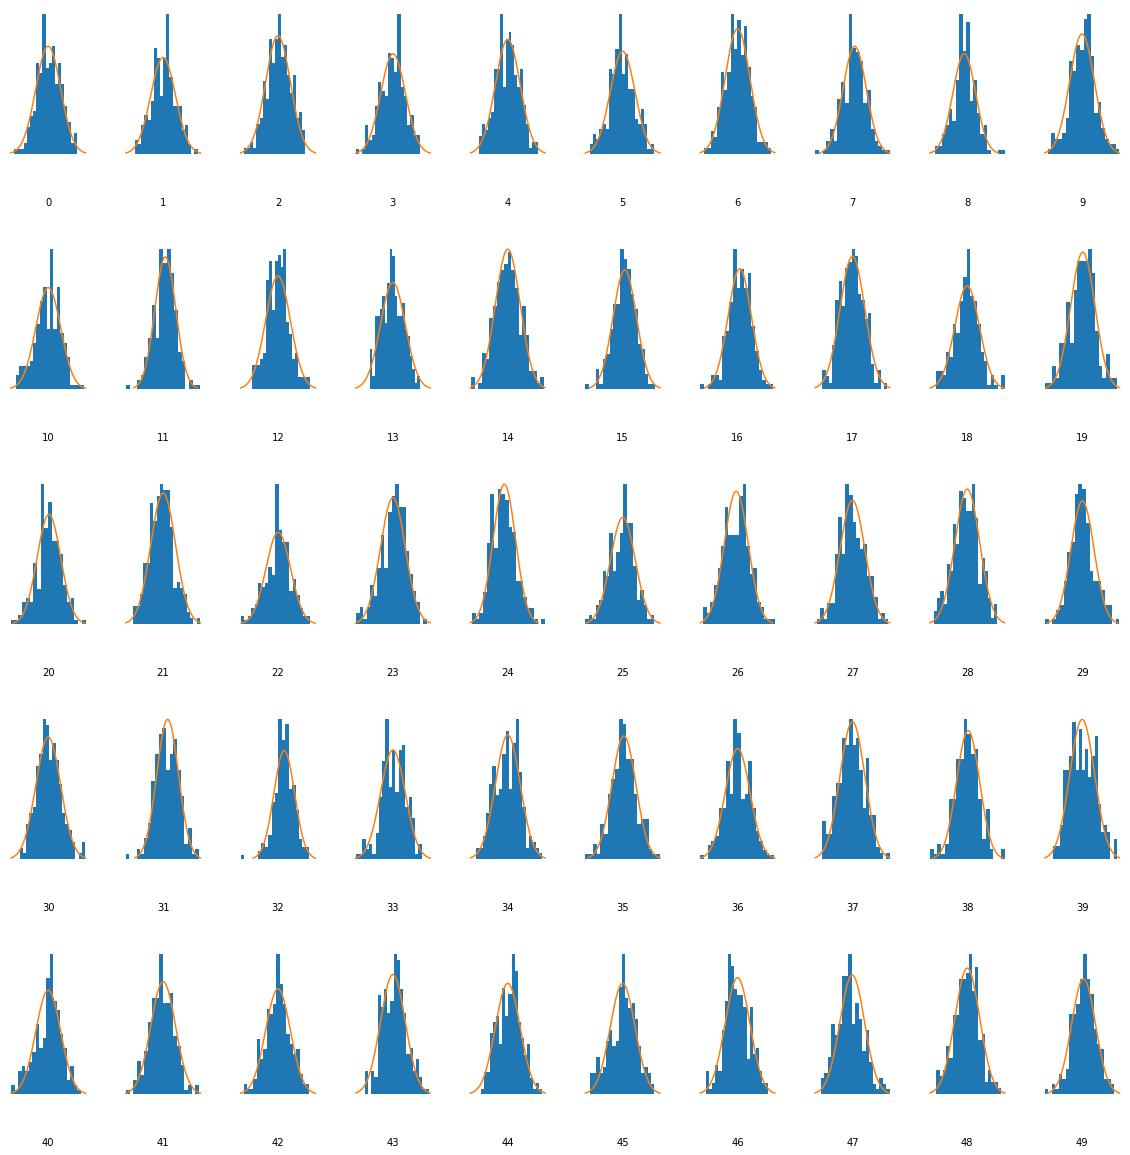

In [35]:
z_test = vae_encoder.predict(example_batch[:200])

x = np.linspace(-3, 3, 300)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()